# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## Import Libraries

In [1]:
%matplotlib inline
# python libraries
from matplotlib.patches import Rectangle
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import sys
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from sklearn import decomposition, metrics, svm, preprocessing
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package
from helpers.helpers import *
from helpers.data_augment import *
from helpers.plots import *
from helpers.cv_scorers import *
from helpers.cross_validator import ParameterSearch
from baselines.helpers import predict_with_dropout_imgs
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *
from keras_helpers.unet import *
from keras_helpers.callbacks import *

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12918062389684641029
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10921197568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17994717970621542408
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [2]:
class_to_remove = 3

# Load Images

In [3]:
path = os.getcwd()

imgs, gt = load_data(path)

# gt to labels
# Next, we need to convert the ground truth (colors) to labels 
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt = gt_color_to_label(gt, colors)

colors = np.asarray(colors)/255

images: 20 
ground truth images: 20 


### Get patches

In [4]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)

(3902, 64, 64, 4)
(964, 64, 64, 4)


# CNN Training

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [5]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [6]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [7]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Roads', 'Buildings', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### Train CNN

In [8]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

/opt/conda/envs/python36/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Instructions for updating:
Use the retry module or similar alternatives.


<Figure size 432x288 with 0 Axes>

In [9]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [10]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### Prediction on Test Set

In [11]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# get accuracy as softmax pseudo-probability
y_pred_acc = np.max(y_pred, axis=-1)

# Get accuracy as margin between highest and second highest class
y_pred_acc_margin = get_acc_net_max_margin(y_pred)

3902/3902 [==============================] - 4s 904us/step


In [12]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[..., np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

In [13]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

### Accuracy Metrics (Test Set)

In [14]:
# Accuracy metrics
y_pred_flattened= np.asarray(y_pred_label.flatten()).astype('int')
y_test_flattened= np.asarray(y_test_nostride.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

         Roads      0.834     0.895     0.864    520742
     Buildings      0.877     0.919     0.897    470587
         Grass      0.983     0.881     0.929    612397
     Bare Soil      0.591     0.746     0.659     66093
         Water      0.961     0.593     0.734     18705
      Railways      0.008     0.009     0.008     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.877     0.873     0.873   1717436

Overall accuracy: 87.264 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Network

In [15]:
# get all predictions in training and test set
# training set
y_pred_tr = model_unet.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=class_to_remove, background=True)

# test set
y_pred_te = model_unet.predict(x_test)
y_pred_te = np.concatenate(remove_overlap(imgs, y_pred_te, ids_test, 64, 32))
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=class_to_remove, background=True)

In [16]:
# get indices of correctly / incorrectly predicted pixels
# with error in known classes
#pred_t_tr = y_pred_label_tr == y_train_label
#pred_f_tr = (y_pred_label_tr != y_train_label) & (y_pred_label_tr != 0)
#pred_t_te = y_pred_label_te == y_test_nostride
#pred_f_te = (y_pred_label_te != y_test_nostride) & (y_pred_label_te != 0)

# only known classes (novely detection)
pred_t_tr = (y_train_label != class_to_remove) & (y_train_label != 0)
pred_f_tr = y_train_label == class_to_remove

pred_t_te = (y_test_nostride != class_to_remove) & (y_test_nostride != 0)
pred_f_te = y_test_nostride == class_to_remove

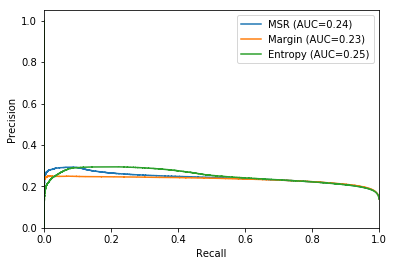

In [17]:
# precision-recall curves

# msr
y_scores = (-get_acc_net_msr(y_pred_te)).flatten()
y_true = pred_f_te.flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(y_pred_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(y_pred_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)


# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)'% pr_auc_msr),
            str.format('Margin (AUC=%.2f)'% pr_auc_margin),
            str.format('Entropy (AUC=%.2f)'% pr_auc_entropy)])

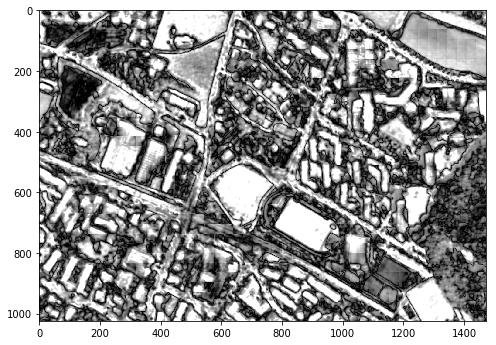

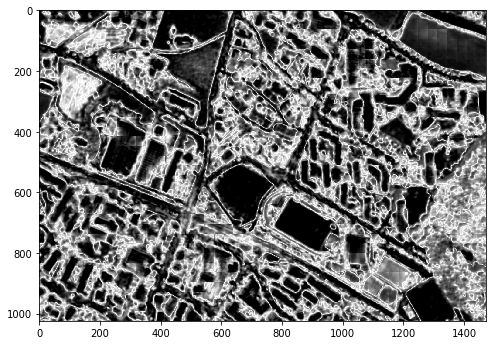

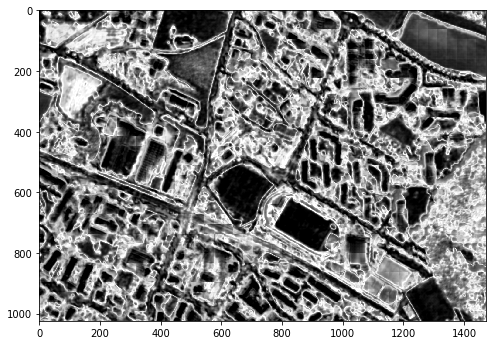

In [18]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(y_pred_te)).flatten(), np.shape(y_test_nostride))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im_msr = convert_patches_to_image(imgs, probas_patches_msr[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im_msr = imgs_stretch_eq([acc_im_msr])[0]
plt.figure(figsize=(8,8))
plt.imshow(acc_im_msr[...,0], cmap='gray')
plt.show()

# margin
probas_patches_margin = np.reshape((1-get_acc_net_max_margin(y_pred_te)).flatten(), np.shape(y_test_nostride))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im_margin = convert_patches_to_image(imgs, probas_patches_margin[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
plt.figure(figsize=(8,8))
plt.imshow(acc_im_margin[...,0], cmap='gray')
plt.show()

# entropy
probas_patches_entropy = np.reshape((1-get_acc_net_entropy(y_pred_te)).flatten(), np.shape(y_test_nostride))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

# show image of DF uncertainty vs. max entropy uncertainty
img_idx=3
acc_im_entropy = convert_patches_to_image(imgs, probas_patches_entropy[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im_entropy = imgs_stretch_eq([acc_im_entropy])[0]
plt.figure(figsize=(8,8))
plt.imshow(acc_im_entropy[...,0], cmap='gray')
plt.show()

## Dropout

In [19]:
# get predictions
y_preds = predict_with_dropout_imgs(model_unet, x_test,
                                    imgs, ids_test, batch_size=500,
                                    n_iter=20)

100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


In [20]:
# get prediction and confidence
prediction = np.mean(y_preds, 0)
probas_dropout = np.mean(np.std(y_preds, -1),0)

In [21]:
# dropout metrics
y_scores = probas_dropout.flatten()
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

AUROC: 0.27, PR AUC: 0.09


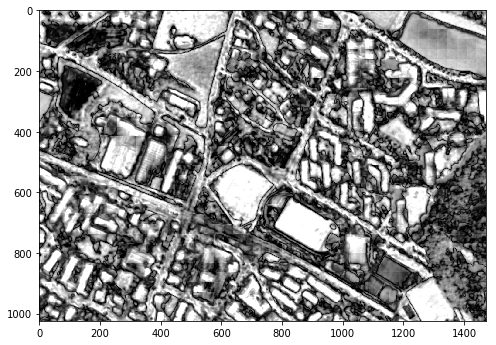

In [22]:
# show image of DF uncertainty vs. max margin uncertainty
probas_patches_margin = np.reshape(y_scores, np.shape(y_test_nostride))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

img_idx=3
acc_im_margin = convert_patches_to_image(imgs, probas_patches_margin[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
plt.figure(figsize=(8,8))
plt.imshow(acc_im_margin[...,0], cmap='gray')
plt.show()

## Retrieve Activations, PCA, t-SNE

In [23]:
# get activations for training Density Forest
act_train_all = get_activations_batch(model_unet, -2, x_train, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_train = act_train_all[pred_t_tr]

100%|██████████| 195/195 [00:03<00:00, 55.78it/s]


In [24]:
# get activations for testing Density Forest
act_test = get_activations_batch(model_unet, -2, x_test, 20, verbose=True)

# remove test activations overlap
act_test = remove_overlap(imgs, act_test, ids_test, patch_size=64, stride=32)
act_test = np.concatenate(np.concatenate(np.concatenate(act_test)))

100%|██████████| 196/196 [00:02<00:00, 85.31it/s]


In [25]:
# get balanced data subset to show in figure
tsne_pts_per_class = 200
dataset_subset_indices = get_balanced_subset_indices(y_test_nostride.flatten(), np.arange(1,9), pts_per_class=tsne_pts_per_class)

In [26]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])
tsne_y = y_test_nostride.flatten()[np.concatenate(dataset_subset_indices)]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.002s...
[t-SNE] Computed neighbors for 1600 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.598844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.213051
[t-SNE] Error after 500 iterations: 0.539839


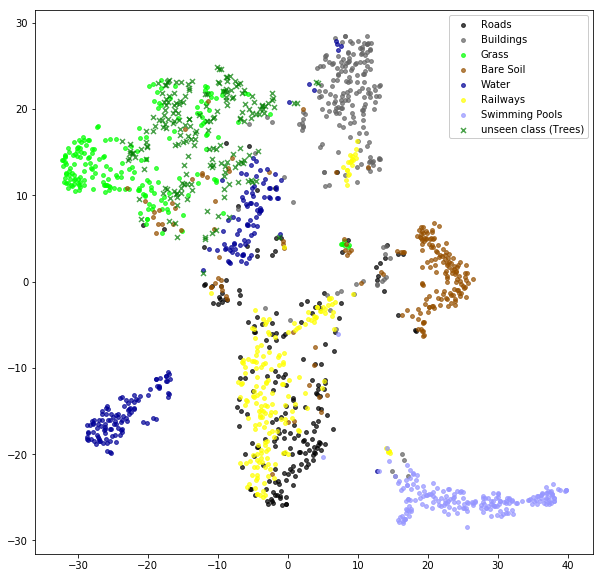

In [27]:
# plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

In [28]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_test)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train = pca.transform(act_train)

# transform training activations
act_train_all = pca.transform(np.concatenate(np.concatenate(act_train_all)))

# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 6 components: 0.96


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.473894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.128952
[t-SNE] Error after 500 iterations: 0.551406


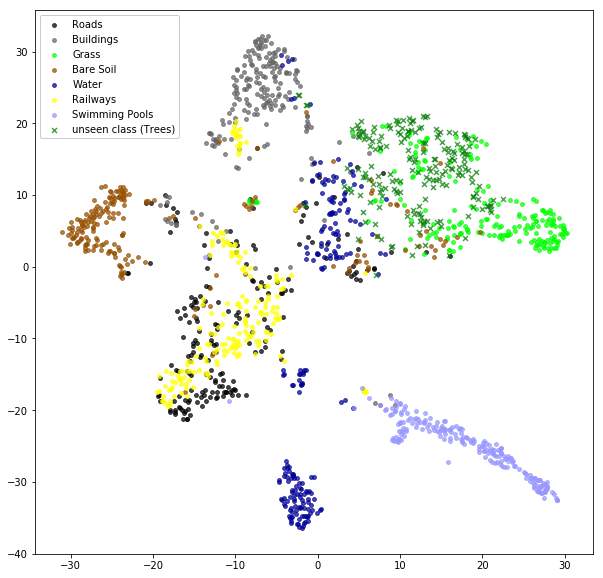

In [29]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])
# tsne without unseen class
tsne_train = tsne_all[tsne_y != class_to_remove]
# plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

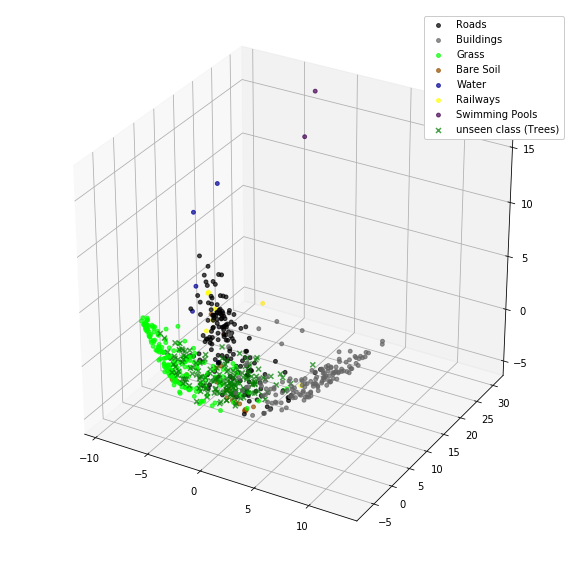

Variance explained by first 3 components: 0.83


In [30]:
# plot first 3 PCA components
plot_pts_3d(act_test[:,:3], y_test_nostride.flatten(), classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.0003)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Variance explained by first 3 components: 0.83


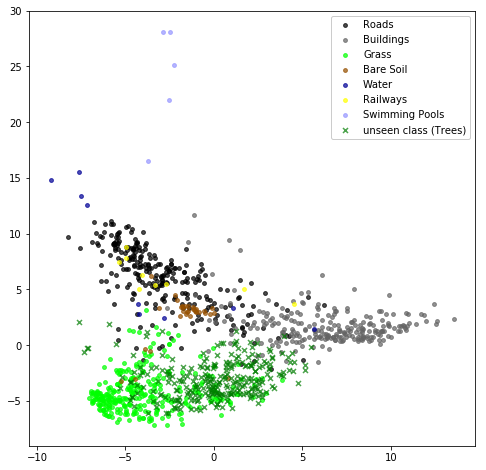

In [31]:
# plot first 2 PCA components
fig, ax = plt.subplots(1,1, figsize=(8,8))
plot_pts_2d(act_test[:,:2], y_test_nostride.flatten(), ax, classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.0005)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## GMM

In [32]:
tuned_parameters = [{'n_components': np.arange(4,12), 
                     'max_iter':[10000]}]

# do parameter search
ps = ParameterSearch(GaussianMixture, tuned_parameters, act_train, act_train_all,
                     pred_f_tr[y_train_label<np.infty], scorer_roc_probas_gmm, 
                     n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.001)
ps.fit()

Trying parameters: {'max_iter': 10000, 'n_components': 4}
Trying parameters: {'max_iter': 10000, 'n_components': 5}
Trying parameters: {'max_iter': 10000, 'n_components': 6}
Trying parameters: {'max_iter': 10000, 'n_components': 7}
Trying parameters: {'max_iter': 10000, 'n_components': 8}
Trying parameters: {'max_iter': 10000, 'n_components': 9}
Trying parameters: {'max_iter': 10000, 'n_components': 10}


[Parallel(n_jobs=40)]: Done   2 out of   8 | elapsed:   27.5s remaining:  1.4min


Trying parameters: {'max_iter': 10000, 'n_components': 11}


[Parallel(n_jobs=40)]: Done   3 out of   8 | elapsed:   36.6s remaining:  1.0min
[Parallel(n_jobs=40)]: Done   4 out of   8 | elapsed:   54.8s remaining:   54.8s
[Parallel(n_jobs=40)]: Done   5 out of   8 | elapsed:   59.9s remaining:   35.9s
[Parallel(n_jobs=40)]: Done   6 out of   8 | elapsed:  1.0min remaining:   20.2s
[Parallel(n_jobs=40)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   8 out of   8 | elapsed:  1.2min finished


In [33]:
ps.best_params

{'max_iter': 10000, 'n_components': 6}

In [34]:
# Fit GMM
gmm = GaussianMixture(**ps.best_params)
#gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)
gmm.fit(draw_subsamples(act_train,.01))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

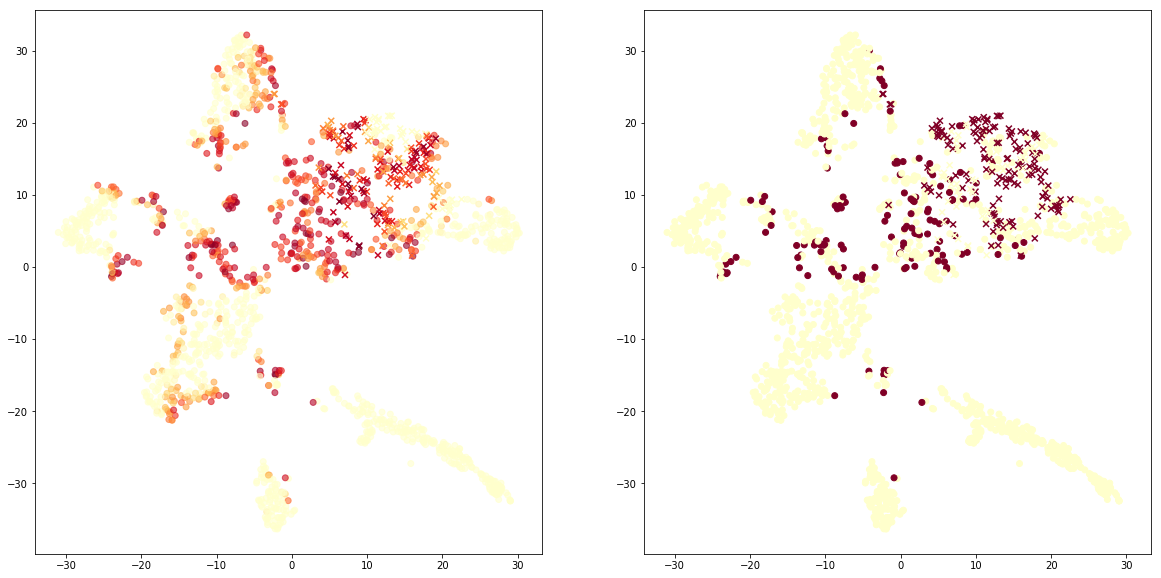

In [35]:
# plot
# indices of correctly / wrongly predicted points
ind = [np.concatenate(dataset_subset_indices)]
pred_f = pred_f_te.flatten()[ind]
pred_t = pred_t_te.flatten()[ind]

# plot colors
probas_gmm_c = imgs_stretch_eq([probas_gmm[...,np.newaxis]])[0,...,0]
colors_plt = plt.cm.YlOrRd(1-probas_gmm_c)[:,:3][ind]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_gmm_c[ind] <
              np.sort(probas_gmm_c[ind])[200])*255)[:,:3]

c_thresh_f = plt.cm.YlOrRd((probas_gmm_c[ind] > 
              np.sort(probas_gmm_c[ind])[200])*255)[:,:3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=colors_plt[pred_t], alpha=.6) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=c_thresh_t[pred_t])  # 300 least certain points in yellow

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=colors_plt[pred_f], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=c_thresh_f[pred_f], marker='x')  # 300 least certain points in yellow
plt.show()

AUROC: 0.58, PR AUC: 0.18


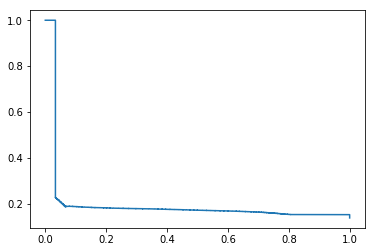

In [36]:
# precision-recall curve
y_scores = -probas_gmm
precision_gmm, recall_gmm, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

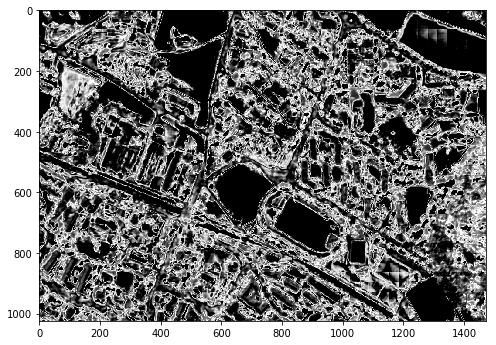

In [37]:
# visualization
probas_patches_gmm = np.reshape(probas_gmm, np.shape(y_test_nostride))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)
probas_patches_gmm = 1-probas_patches_gmm

# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im_gmm = convert_patches_to_image(imgs, probas_patches_gmm[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im_gmm = imgs_stretch_eq([acc_im_gmm])[0]
plt.figure(figsize=(8,8))
plt.imshow(acc_im_gmm[...,0], cmap='gray')
plt.show()


# SVM

In [38]:
act_train_svm = preprocessing.scale(act_train)
act_train_all_svm = preprocessing.scale(act_train_all)
act_test_svm = preprocessing.scale(act_test)

In [39]:
tuned_parameters=[{'kernel':['rbf'],
                   'nu':[.001, .5, .99]
                   },
                 {'kernel':['poly'],
                  'degree':np.arange(1, 17),
                  'nu':[1e-4, 1e-3, 1e-2, .1, .3, .5],
                  'max_iter':[10000]}]

# do parameter search
ps = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm, act_train_all_svm, 
                     pred_f_tr[y_train_label<np.infty], scorer_roc_probas_svm, n_iter=5,
                     verbosity=10, n_jobs=-1, subsample_train=.001, subsample_test=.001)
ps.fit()

ps.best_params

Trying parameters: {'kernel': 'rbf', 'nu': 0.001}
Trying parameters: {'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'kernel': 'rbf', 'nu': 0.99}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:  1.4min


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:  2.0min


Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done  30 out of  99 | elapsed:  2.6min remaining:  5.9min
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}


[Parallel(n_jobs=40)]: Done  40 out of  99 | elapsed:  2.9min remaining:  4.3min


Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=40)]: Done  50 out of  99 | elapsed:  3.3min remaining:  3.3min


Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done  60 out of  99 | elapsed:  3.7min remaining:  2.4min


Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}


[Parallel(n_jobs=40)]: Done  70 out of  99 | elapsed:  4.1min remaining:  1.7min


Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done  80 out of  99 | elapsed:  4.5min remaining:  1.1min


Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  90 out of  99 | elapsed:  4.8min remaining:   29.1s


Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  99 out of  99 | elapsed:  5.3min finished


{'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}

In [40]:
ps.best_params

{'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}

In [41]:
# Fit SVM
clf_svm = svm.OneClassSVM(**ps.best_params)
#clf_svm = svm.OneClassSVM(kernel='poly', degree=12, nu=.2)
clf_svm.fit(draw_subsamples(act_train_svm, .001))

OneClassSVM(cache_size=200, coef0=0.0, degree=1, gamma='auto', kernel='poly',
      max_iter=10000, nu=0.001, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [42]:
# predict
ind = [np.concatenate(dataset_subset_indices)]
probas_svm = clf_svm.decision_function(act_test_svm[ind])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

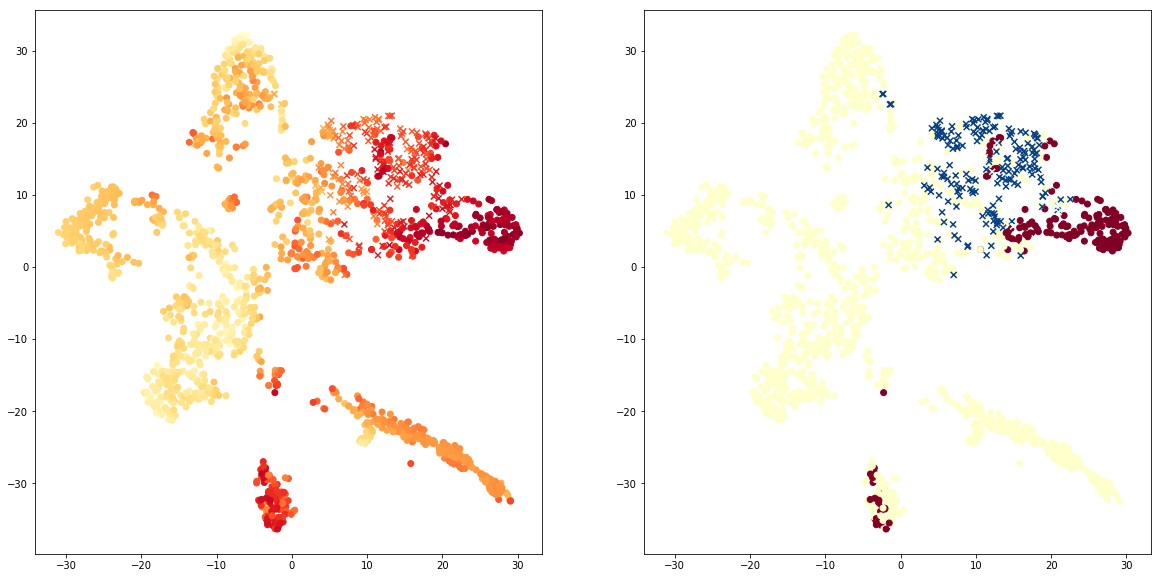

In [43]:
# plot
# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[ind]
pred_t = pred_t_te.flatten()[ind]

# plot colors
#probas_svm_c = imgs_stretch_eq([probas_svm])[0,...,0]
probas_svm_c = probas_svm[...,0]
colors_plt = plt.cm.YlOrRd(1-probas_svm_c)[...,:3]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_svm_c <
              np.sort(probas_svm_c)[200])*255)[:,:3]

c_thresh_f = plt.cm.GnBu((probas_svm_c > 
              np.sort(probas_svm_c)[200])*255)[:,:3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=colors_plt[pred_t])#, alpha=.6) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=c_thresh_t[pred_t])  # 300 least certain points in yellow

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=colors_plt[pred_f], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=c_thresh_f[pred_f], marker='x')  # 300 least certain points in yellow
plt.show()

In [44]:
probas_svm = clf_svm.decision_function(act_test_svm)
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [45]:
# precision-recall curve
y_scores = -probas_svm
# PR
precision_svm, recall_svm, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

In [46]:
auroc_svm, pr_auc_svm

(0.6975727145870025, 0.1891034554424348)

In [47]:
probas_svm.shape

(3948544, 1)

## Density Forest

**Parameters importance:**
- `n_trees`: minor relevance (10 is enough)
- `min_subset`: important, smaller number <-> more clusters (requires `subset_data` to be high enough)
- `subset_data`: irrelevant, but should be higher if `min_subset` is lower
- `max_depth`: important, greater depth <-> more clusters
- `fact_improvement`: important, smaller minimum factor <-> more clusters
- `n_max_dim`: unimportant, better to set to 0


In [48]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=100,
                       subsample_pct=.1, n_jobs=-1, verbose=10,
                       fact_improvement=0)

In [49]:
# fit to training data
clf_df.fit(tsne_train)

Number of points on which to train each tree: 140
Minimum number of points in each leaf: 14


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done  32 out of 100 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=40)]: Done  43 out of 100 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=40)]: Done  54 out of 100 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  65 out of 100 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=40)]: Done  76 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  87 out of 100 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=40)]: Done  98 out of 100 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.2s finished


Number of created root nodes: 100
Mean number of clusters created per tree: 7


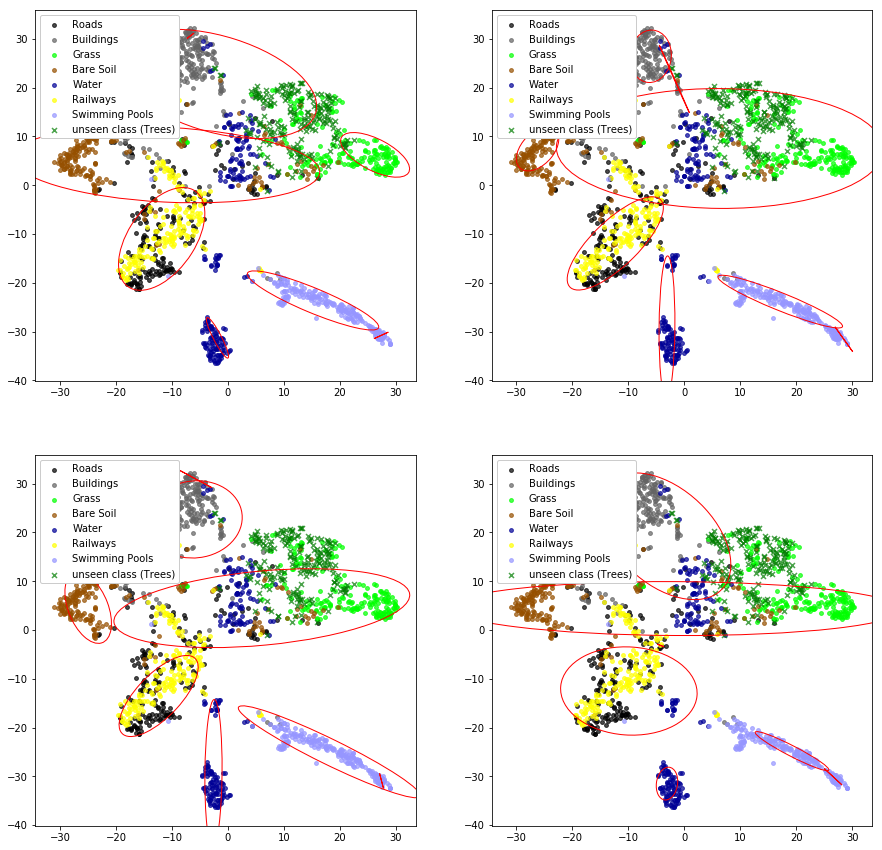

In [50]:
# Show ellipses on plot
fig, axes = plt.subplots(2, 2, figsize=(15,15)) 
for i in range(4):
    plot_pts_2d(tsne_all, tsne_y, axes[int(i/2)][np.mod(i,2)], classes_to_keep, names, colors, 
            class_to_remove=class_to_remove)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(axes[int(i/2)][np.mod(i,2)], means, covs)

/raid/home/cwendl/SIE-Master/Code/density_forest/plots.py:238: RuntimeWarning: invalid value encountered in sqrt
  w, h = 2 * nstd * np.sqrt(vals)


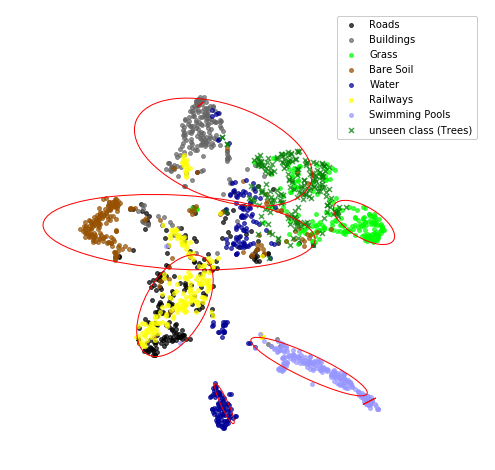

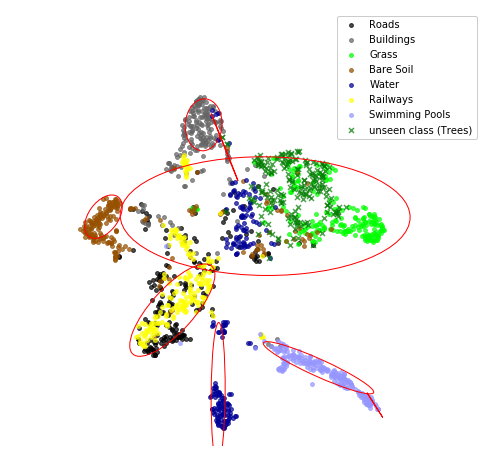

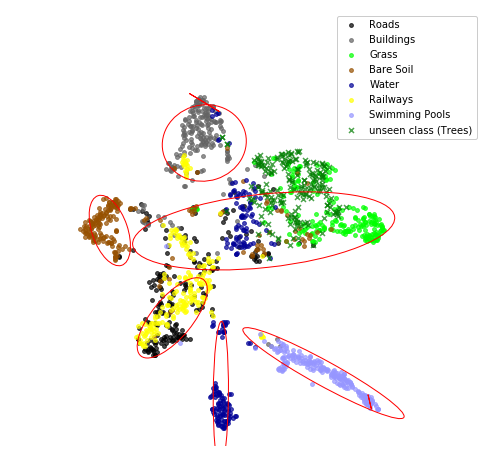

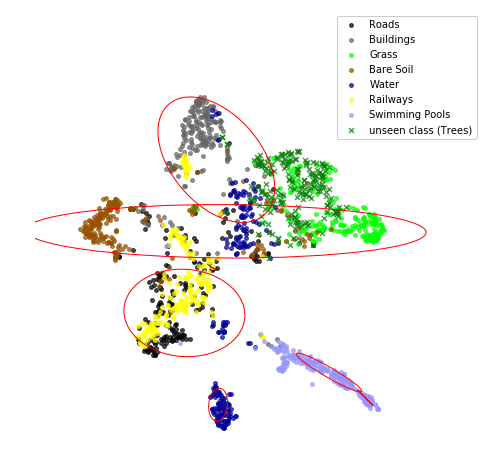

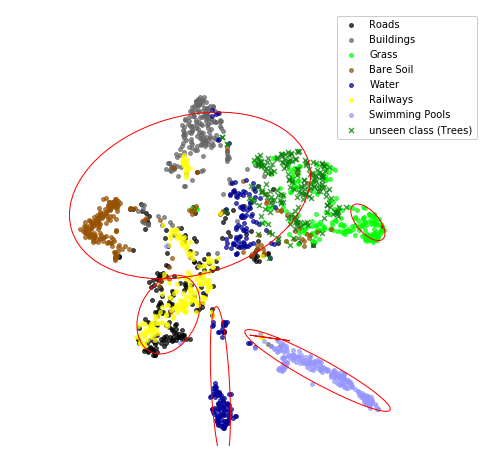

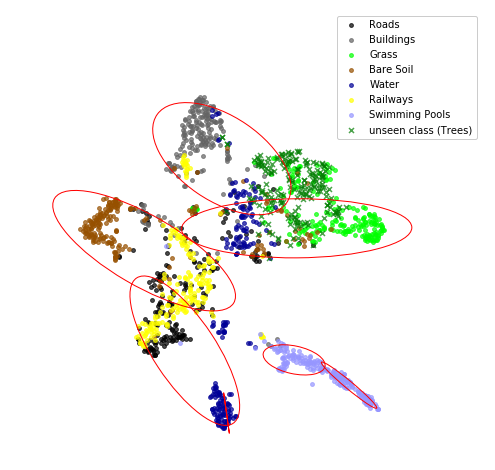

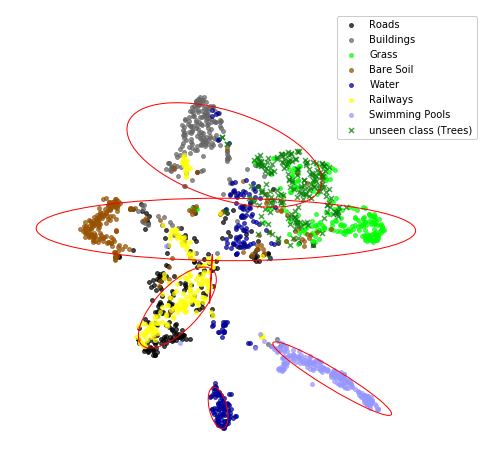

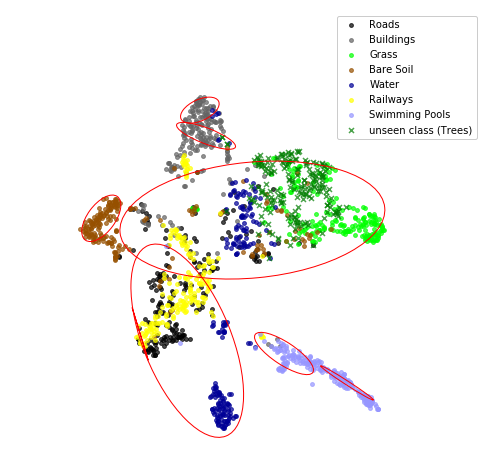

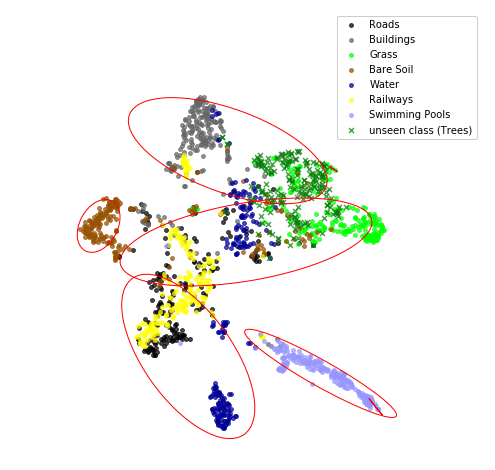

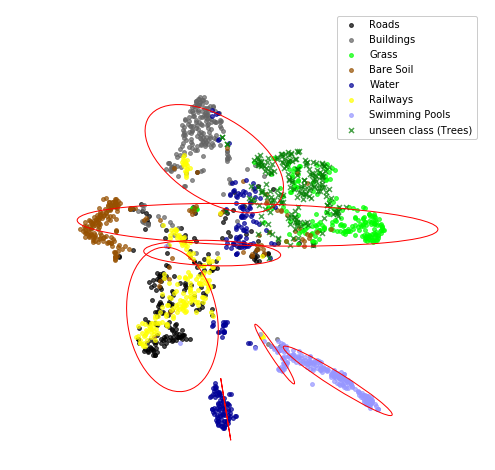

In [51]:
# export some ellipses for GIF

for i in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(8,8)) 
    plt.xlim([-40,50])
    plt.ylim([-40,50])
    plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, 
            class_to_remove=class_to_remove)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(ax, means, covs)
    plt.axis('off')
    plt.savefig("../Figures/Zurich/GIF/TSNE_act_wo_cl" + str(class_to_remove) + "_"+str(i)+".pdf", bbox_inches='tight', pad_inches=0)
    %clear

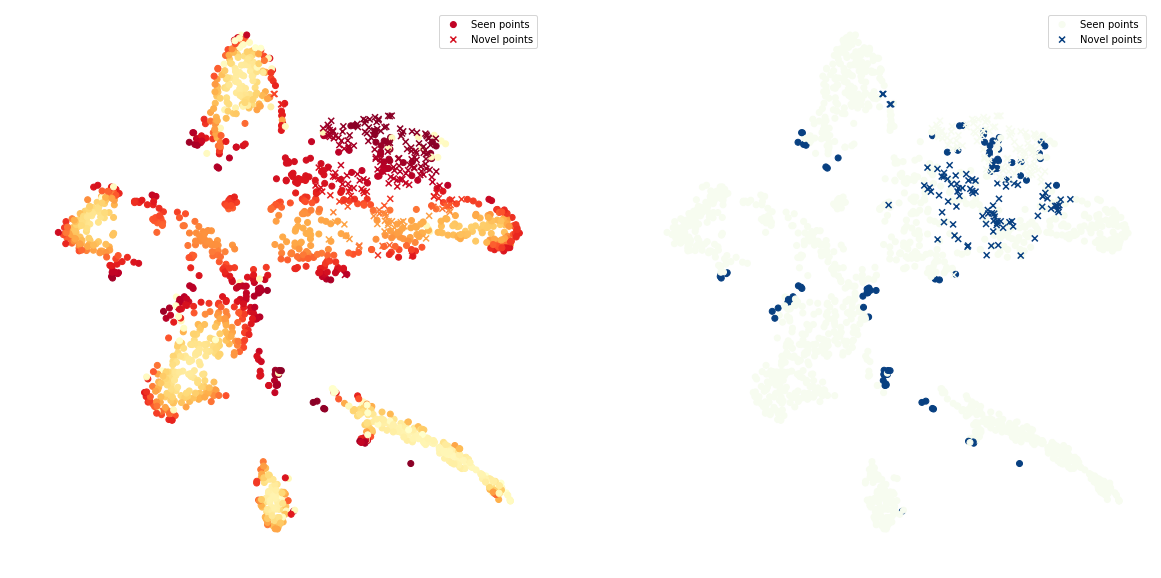

In [52]:
# plot

# get probabilities for all images
probas_df = np.log(clf_df.predict(tsne_all))

# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[ind]
pred_t = pred_t_te.flatten()[ind]

# plot colors
probas_df_c = imgs_stretch_eq(probas_df[np.newaxis,...,np.newaxis])[0,...,0]
#probas_df_c = probas_df
colors_plt = plt.cm.YlOrRd(1-probas_df_c)[...,:3]

# threshold for second plot
c_thresh_t = plt.cm.GnBu((probas_df <
              np.sort(probas_df)[tsne_pts_per_class])*255)[:,:3]

c_thresh_f = plt.cm.GnBu((probas_df > 
              np.sort(probas_df)[tsne_pts_per_class])*255)[:,:3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=colors_plt[pred_t])#, alpha=.6) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=c_thresh_t[pred_t])  # 300 least certain points in yellow

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=colors_plt[pred_f], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=c_thresh_f[pred_f], marker='x')  # 300 least certain points in yellow
[axes[i].legend(['Seen points', 'Novel points']) for i in range(2)]
[axes[i].set_axis_off() for i in range(2)]
extent = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches=extent, pad_inches=0)
plt.show()

### Fit on real data

In [53]:
tuned_parameters=[{'max_depth':[2, 3, 4],
                   'min_subset':[.1],
                   'n_trees':[10],
                   'n_max_dim':[0],
                   'n_jobs':[-1],
                   'subsample_pct':[.0002],
                   'fact_improvement':[.4, .5, .6],
                   'verbose':[0],
                  }
                 ]

# do parameter search
ps = ParameterSearch(DensityForest, tuned_parameters, act_train[...,:3], act_train_all[...,:3], 
                     pred_f_tr[y_train_label<np.infty], scorer_roc_probas_df,
                     n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, subsample_test=.001)

print("Testing %i combinations %i times:" % (len(ps.combinations), ps.n_iter))
print(ps.combinations)
ps.fit()

Testing 9 combinations 3 times:
[{'fact_improvement': 0.4, 'max_depth': 2, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
 {'fact_improvement': 0.4, 'max_depth': 3, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
 {'fact_improvement': 0.4, 'max_depth': 4, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
 {'fact_improvement': 0.5, 'max_depth': 2, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
 {'fact_improvement': 0.5, 'max_depth': 3, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
 {'fact_improvement': 0.5, 'max_depth': 4, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
 {'fact_improvement': 0.6, 'max_depth': 2, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s remaining:    0.0s


Trying parameters: {'fact_improvement': 0.4, 'max_depth': 3, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.0s remaining:    0.0s


Trying parameters: {'fact_improvement': 0.4, 'max_depth': 4, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


Trying parameters: {'fact_improvement': 0.5, 'max_depth': 2, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


Trying parameters: {'fact_improvement': 0.5, 'max_depth': 3, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


Trying parameters: {'fact_improvement': 0.5, 'max_depth': 4, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min remaining:    0.0s


Trying parameters: {'fact_improvement': 0.6, 'max_depth': 2, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s


Trying parameters: {'fact_improvement': 0.6, 'max_depth': 3, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s


Trying parameters: {'fact_improvement': 0.6, 'max_depth': 4, 'min_subset': 0.1, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min finished


In [54]:
ps.best_params

{'fact_improvement': 0.4,
 'max_depth': 4,
 'min_subset': 0.1,
 'n_jobs': -1,
 'n_max_dim': 0,
 'n_trees': 10,
 'subsample_pct': 0.0002,
 'verbose': 0}

In [55]:
ps.best_params['n_trees']=20
ps.best_params['verbose']=10
ps.best_params['batch_size']=10000

In [56]:
# Create DensityForest instance
#clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=20,  # best parameters for class 1 so far
#                       subsample_pct=.0002, n_jobs=-1, verbose=10,
#                       fact_improvement=.5, batch_size=10000)
clf_df = DensityForest(**(ps.best_params))

In [57]:
clf_df.fit(act_train[...,:3])

Number of points on which to train each tree: 1634
Minimum number of points in each leaf: 163


[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:    7.0s remaining:   28.1s
[Parallel(n_jobs=40)]: Done   7 out of  20 | elapsed:    7.1s remaining:   13.3s
[Parallel(n_jobs=40)]: Done  10 out of  20 | elapsed:    7.3s remaining:    7.3s
[Parallel(n_jobs=40)]: Done  13 out of  20 | elapsed:    7.4s remaining:    4.0s
[Parallel(n_jobs=40)]: Done  16 out of  20 | elapsed:    7.5s remaining:    1.9s


Number of created root nodes: 20
Mean number of clusters created per tree: 15


[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:    7.8s finished


In [58]:
# get probabilities for all images
probas_df = clf_df.predict(act_test[...,:3])

Total steps: 394
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:    7.9s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:   11.4s
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:   13.6s
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   16.0s
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:   18.2s
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   20.4s
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:   23.2s
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:   26.0s
[Parallel(n_jobs=40)]: Done 185 tasks      | elapsed:   28.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:   37.1s
[Parallel(n_jobs=40)]: Done 233 tasks      | elapsed:   39.7s
[Parallel(n_jobs=40)]: Done 258 tasks      | elapsed:   42.9s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   52.2s
[Parallel(n_jobs=40)]: Done 312 tasks      | elapsed:   55.3s
[Paralle

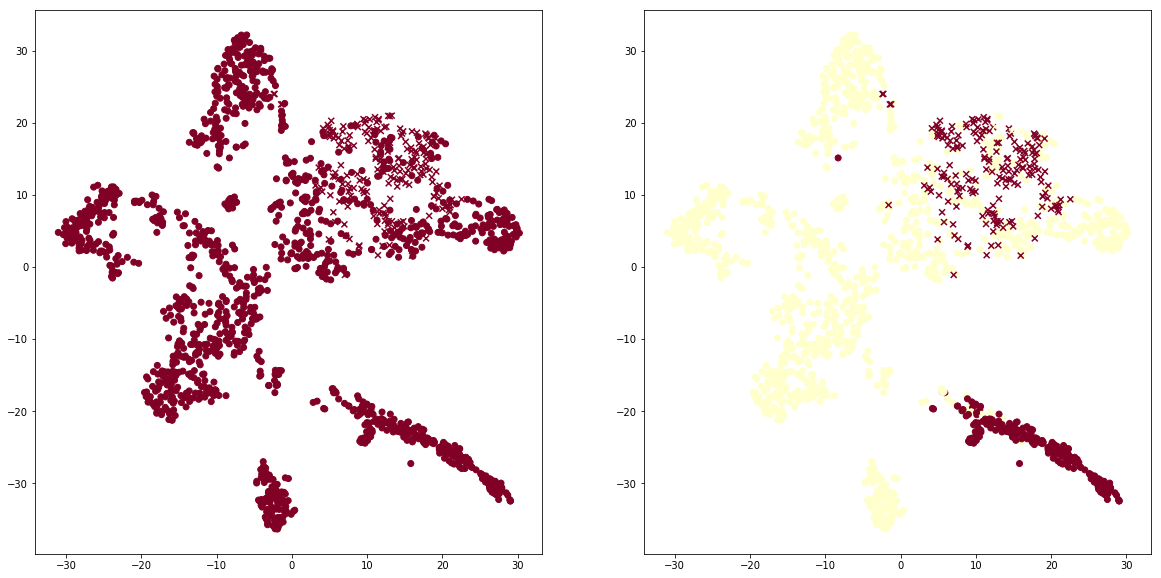

In [59]:
# plot
# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[ind]
pred_t = pred_t_te.flatten()[ind]

# plot colors
probas_df_c = imgs_stretch_eq(probas_df[ind,np.newaxis])[0,...,0]
probas_df_c = probas_df[ind]
colors_plt = plt.cm.YlOrRd(1-np.log(probas_df_c))[...,:3]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_df_c <
              np.sort(probas_df_c)[200])*255)[:,:3]

c_thresh_f = plt.cm.YlOrRd((probas_df_c > 
              np.sort(probas_df_c)[200])*255)[:,:3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=colors_plt[pred_t])#, alpha=.6) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=c_thresh_t[pred_t])  # 300 least certain points in yellow

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=colors_plt[pred_f], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=c_thresh_f[pred_f], marker='x')  # 300 least certain points in yellow
#axes[0].savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches='tight', pad_inches=0)

### Post-Treatment

In [60]:
# reshape probas to (n_patches, patch_size, patch_size)
probas_patches_df = np.reshape(probas_df, np.shape(y_test_nostride))

# transformations
probas_patches_df -= np.nanmin(probas_patches_df)
probas_patches_df /= np.nanmax(probas_patches_df)

### Metrics

In [61]:
# metrics
y_scores = -probas_df
filt = y_test_nostride.flatten()!=0

# PR
precision_df, recall_df, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.67, PR AUC: 0.25


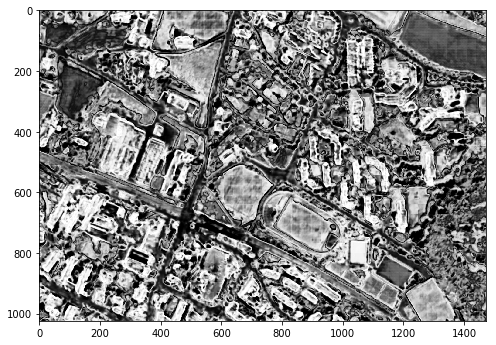

In [62]:
# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im_df = convert_patches_to_image(imgs, probas_patches_df[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im_df = imgs_stretch_eq([acc_im_df])[0]
plt.figure(figsize=(8,8))
plt.imshow(acc_im_df[...,0], cmap='gray')
plt.show()

## Plot Results

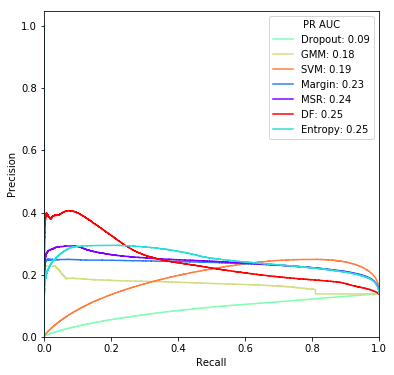

In [63]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]
recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, precision_gmm, precision_svm, precision_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_pr)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/Zurich/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

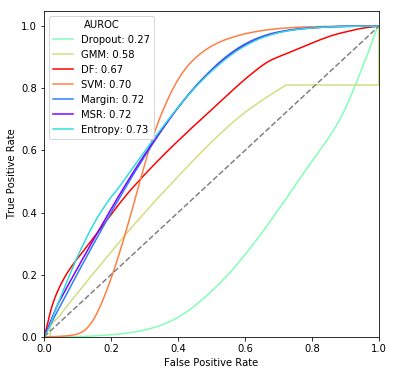

In [64]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_auc)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0,1],[0,1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/Zurich/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()